In [1]:
import os
import scipy.io

import numpy as np

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


1. Data prepartion

In [21]:
# Configuration parameters
num_channels = 128
length_timebins = 159136


# Load file
filepath = r"F:\RiceStudy\BCI\speech_neuroprosthesis\data\tuningTasks"
filename = "t12.2022.04.26_phonemes.mat"
matfile_path = os.path.join(filepath, filename)

tuning_data = scipy.io.loadmat(matfile_path)


# Generate "phoneme - neural activty" chart
# Extract neural activity and phonemes records
## Phonemes are recorded in tuning_data['trailCues']

## extract indexes in records

gotrial_start = np.array(tuning_data['goTrialEpochs'][:, 0])
gotrial_end = np.array(tuning_data['goTrialEpochs'][:, 1])

phonemes_chart = ['B','CH','NOTHING','D','F','G','HH','JH','K','L','ER','M','N','NG','P','R','S','SH','DH','T','TH', 'V','W',\
    'Y','Z','ZH','OY','EH','EY','UH','IY','OW','UW','IH','AA','AW','AY','AH','AO','AE']

## extract and rearrange neural activities
### def Z-score. input an numpy array
def z_score(arr):
    x = arr.copy()
    mean = np.mean(x)
    std = np.std(x)
    if std == 0:
        return 0
    return (x - mean) / std


### def subtraction mean. input an numpy array
def subt_mean(arr):
    x = arr.copy()
    mean = np.mean(x)
    return x - mean

### generate dictionary 
### dictionary for phoneme's neural activities
phonemes_indices = {}
for i in range(len(phonemes_chart)):
    key = phonemes_chart[i]
    value = np.where(tuning_data['trialCues'] == (i + 1))[0]
    phonemes_indices[key] = value


### Slice phonemese with aligenment by audio envelope, z-scored globally

slicecut_left = 40
slicecut_right = 0


sp_temp = z_score(tuning_data['spikePow'][:, : num_channels].copy())



phonemes_neuralact = {}
for i in range(len(phonemes_chart)):
    trial_begins = [max(0, gotrial_start[phonemes_indices[phonemes_chart[i]][j]] - 10) for j in range(len(phonemes_indices[phonemes_chart[i]]))]
    trial_ends = [min(length_timebins, gotrial_end[phonemes_indices[phonemes_chart[i]][j]] - 10) for j in range(len(phonemes_indices[phonemes_chart[i]]))]

    trialslice_sp = np.zeros((slicecut_right + slicecut_left, num_channels))

    for j in range(len(phonemes_indices[phonemes_chart[i]])): # iterate by trials for each phoneme/condition
        audio_loudest = max(tuning_data['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]])
        audio_loudest_index = np.where(tuning_data['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]] == audio_loudest)[0][0] + trial_begins[j] - 1

        slice_left = audio_loudest_index - slicecut_left
        slice_right = audio_loudest_index + slicecut_right

        ### read a trial's neural activity data
        if slice_left >= 0 and slice_right <= length_timebins:
            trialslice_sp_temp = sp_temp[slice_left : slice_right, :] # Spike Power

        elif slice_left < 0:
            tempp_zeros = np.zeros((0 - slice_left, num_channels)) # contemporarily supplementary array
            trialslice_sp_temp = np.concatenate((tempp_zeros, sp_temp[slice_left : slice_right, :] )) # Spike Power

        elif slice_right > length_timebins:
            tempp_zeros = np.zeros((slice_right - length_timebins, num_channels)) # contemporarily supplementary array
            trialslice_sp_temp = np.concatenate((sp_temp[slice_left : slice_right, :] , tempp_zeros)) # Spike Power

        trialslice_sp = trialslice_sp + trialslice_sp_temp

    trialslice_sp /= len(phonemes_indices[phonemes_chart[i]])

    key = phonemes_chart[i]
    phonemes_neuralact[key] = trialslice_sp

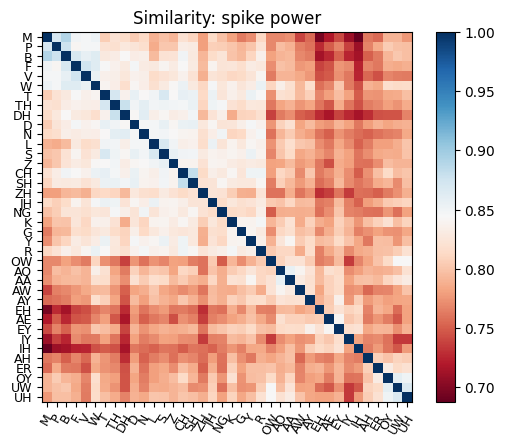

<Figure size 640x480 with 0 Axes>

In [ ]:
# similarity matrix
sp_flattened = [np.reshape(phonemes_neuralact[phonemes_chart[i]], -1) for i in range(len(phonemes_chart))]


# def of cross product calculation
def cross_product(x, y):
    if len(x) != len(y):
        return 0
    
    t = 0
    for i in range(len(x)):
        t += x[i] * y[i]

    return t


# def of representation similarity calculation
def repre_similarity(x, y):
    if cross_product(x, x) == 0 or cross_product(y, y) == 0:
        return 0
    if len(x) != len(y):
        return 0
    
    t = 0
    return cross_product(x, y) / np.sqrt(cross_product(x, x)) / np.sqrt(cross_product(y, y))


map_similarity = np.zeros((len(phonemes_chart), len(phonemes_chart)))

consonant_clusteredchart = ['M', 'B', 'P', 'F', 'V', 'W', 'T', 'TH', 'DH', 'D', 'N', 'L', 'S', 'Z', 'CH', 'SH', 'ZH', 'JH', 'NG', 'K', 'G', 'Y', 'R']
vowel_clusteredchart = ['OW', 'AO', 'AA', 'AW', 'AY', 'EH', 'AE', 'EY', 'IY', 'IH', 'AH', 'ER', 'OY', 'UW', 'UH']

phoneme_clusteredchart = np.append(consonant_clusteredchart[:], vowel_clusteredchart[:])

## generate shuffle map for the arrays according to phoneme clustering
similarity_sp = np.zeros((len(phoneme_clusteredchart), len(phoneme_clusteredchart)))

shuffle_sp_flattened = [sp_flattened[phonemes_chart.index(phone)] for phone in phoneme_clusteredchart]

for i in range(len(phoneme_clusteredchart)):
    for j in range(i, len(phoneme_clusteredchart)):
        similarity_sp[i, j] = repre_similarity(shuffle_sp_flattened[i], shuffle_sp_flattened[j])
        similarity_sp[j, i] = similarity_sp[i, j]

## plot similarity
plt.imshow(similarity_sp, cmap='RdBu')
plt.title("Similarity: spike power")
plt.colorbar()
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation=60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9)
plt.show()

plt.clf()

In [ ]:
# confusion matrix
## classify


-0.6245865076780319

In [11]:
###############      DEBUG      ################
np.reshape(phonemes_neuralact['AA'], -1)

array([-0.65953789, -0.15772926,  0.86264252, ..., -0.03323606,
        0.15310456, -0.27102225])